In [1]:
import glob
import os

import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')

import pandas as pd
import numpy as np

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from torch.utils.data.dataloader import DataLoader

from neuroformer.model_neuroformer import load_model_and_tokenizer
from neuroformer.utils import get_attr
from neuroformer.utils import (set_seed, running_jupyter, 
                                 all_device, recursive_print,
                                 create_modalities_dict)
from neuroformer.datasets import load_visnav, load_V1AL

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

from neuroformer.default_args import DefaultArgs, parse_args

if running_jupyter(): # or __name__ == "__main__":
    print("Running in Jupyter")
    args = DefaultArgs()
    # args.dataset = "medial"
    # args.ckpt_path = "./models/NF.15/Visnav_VR_Expt/medial/Neuroformer/predict_all_behavior/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25"
    
    args.dataset = "lateral"
    args.ckpt_path = "./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/demo/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25"
    args.predict_modes = ['speed']
else:
    print("Running in terminal")
    args = parse_args()


# SET SEED - VERY IMPORTANT
set_seed(args.seed)

print(f"CONTRASTIVE {args.contrastive}")
print(f"VISUAL: {args.visual}")
print(f"PAST_STATE: {args.past_state}")


config, tokenizer, model = load_model_and_tokenizer(args.ckpt_path)

/local/home/antonis/.conda/envs/neuroformer_clean/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running in Jupyter
CONTRASTIUVEEEEEEE False
VISUAL: True
PAST_STATE: True


11/22/2023 17:38:37 - INFO - neuroformer.model_neuroformer -   number of parameters: 2.510515e+07


256 9
 ///// <=----- Loading model from ./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/demo/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25 -----=> \\\


In [2]:
""" 

-- DATA --
neuroformer/data/OneCombo3_V1AL/
df = response
video_stack = stimulus
DOWNLOAD DATA URL = https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=sharing


"""
print(f"DATASET: {args.dataset}")
if args.dataset in ["lateral", "medial"]:
    data, intervals, train_intervals, \
    test_intervals, finetune_intervals, \
    callback = load_visnav(args.dataset, config, 
                           selection=config.selection if hasattr(config, "selection") else None)
elif args.dataset == "V1AL":
    data, intervals, train_intervals, \
    test_intervals, finetune_intervals, \
    callback = load_V1AL(config)

spikes = data['spikes']
stimulus = data['stimulus']

DATASET: lateral


In [3]:
window = config.window.curr
window_prev = config.window.prev
dt = config.resolution.dt


# -------- #

spikes_dict = {
    "ID": data['spikes'],
    "Frames": data['stimulus'],
    "Interval": intervals,
    "dt": config.resolution.dt,
    "id_block_size": config.block_size.id,
    "prev_id_block_size": config.block_size.prev_id,
    "frame_block_size": config.block_size.frame,
    "window": config.window.curr,
    "window_prev": config.window.prev,
    "frame_window": config.window.frame,
}

""" structure:
{
    type_of_modality:
        {name of modality: {'data':data, 'dt': dt, 'predict': True/False},
        ...
        }
    ...
}
"""



" structure:\n{\n    type_of_modality:\n        {name of modality: {'data':data, 'dt': dt, 'predict': True/False},\n        ...\n        }\n    ...\n}\n"

In [4]:
from neuroformer.data_utils import NFDataloader

n_test_iters = 5000
n_test_idx = np.random.choice(len(test_intervals), n_test_iters, replace=False)
test_intervals = test_intervals[n_test_idx]

modalities = create_modalities_dict(data, config.modalities) if hasattr(config, "modalities") else None
frames = {'feats': stimulus, 'callback': callback, 'window': config.window.frame, 'dt': config.resolution.dt}

train_dataset = NFDataloader(spikes_dict, tokenizer, config, dataset=args.dataset, 
                             frames=frames, intervals=train_intervals, modalities=modalities)
test_dataset = NFDataloader(spikes_dict, tokenizer, config, dataset=args.dataset, 
                            frames=frames, intervals=test_intervals, modalities=modalities)
finetune_dataset = NFDataloader(spikes_dict, tokenizer, config, dataset=args.dataset, 
                                frames=frames, intervals=finetune_intervals, modalities=modalities)

    
# print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')
iterable = iter(train_dataset)
x, y = next(iterable)
recursive_print(x)

# Update the config
config.id_vocab_size = tokenizer.ID_vocab_size

# Create a DataLoader
loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)
iterable = iter(loader)
x, y = next(iterable)
recursive_print(y)
preds, features, loss = model(x, y)

# Set training parameters
MAX_EPOCHS = 300
BATCH_SIZE = 32 * 5
SHUFFLE = True

if config.gru_only:
    model_name = "GRU"
elif config.mlp_only:
    model_name = "MLP"
elif config.gru2_only:
    model_name = "GRU_2.0"
else:
    model_name = "Neuroformer"

CKPT_PATH = args.ckpt_path

# Define the parameters
sample = True
top_p = 0.95
top_p_t = 0.95
temp = 1.
temp_t = 1.
frame_end = 0
true_past = args.true_past
get_dt = True
gpu = True
pred_dt = True

# # Run the prediction function
# results_trial = generate_spikes(model, test_dataset, window, 
#                                 window_prev, tokenizer, 
#                                 sample=sample, top_p=top_p, top_p_t=top_p_t, 
#                                 temp=temp, temp_t=temp_t, frame_end=frame_end, 
#                                 true_past=true_past,
#                                 get_dt=get_dt, gpu=gpu, pred_dt=pred_dt,
#                                 plot_probs=False)

# # Create a filename string with the parameters
# filename = f"results_trial_sample-{sample}_top_p-{top_p}_top_p_t-{top_p_t}_temp-{temp}_temp_t-{temp_t}_frame_end-{frame_end}_true_past-{true_past}_get_dt-{get_dt}_gpu-{gpu}_pred_dt-{pred_dt}.pkl"

# # Save the results in a pickle file
# save_inference_path = os.path.join(CKPT_PATH, "inference")
# if not os.path.exists(save_inference_path):
#     os.makedirs(save_inference_path)

# print(f"Saving inference results in {os.path.join(save_inference_path, filename)}")

# with open(os.path.join(save_inference_path, filename), "wb") as f:
#     pickle.dump(results_trial, f)


Min Interval: 0.1
Intervals:  24092
Window:  0.05
Window Prev:  0.05
Population Size:  2026
ID Population Size:  2026
DT Population Size:  9
Using explicitly passed intervals
Min Interval: 0.1
Intervals:  5000
Window:  0.05
Window Prev:  0.05
Population Size:  2026
ID Population Size:  2026
DT Population Size:  9
Using explicitly passed intervals
Min Interval: 0.1
Intervals:  240
Window:  0.05
Window Prev:  0.05
Population Size:  2026
ID Population Size:  2026
DT Population Size:  9
Using explicitly passed intervals
id_prev torch.Size([700]) torch.int64
dt_prev torch.Size([700]) torch.float32
pad_prev torch.Size([]) torch.int64
id torch.Size([100]) torch.int64
dt torch.Size([100]) torch.float32
pad torch.Size([]) torch.int64
interval torch.Size([]) torch.float32
trial torch.Size([]) torch.int64
frames torch.Size([1, 3, 30, 100]) torch.float32
cid torch.Size([2]) torch.float32
pid torch.Size([2]) torch.float32
id torch.Size([2, 100]) torch.int64
dt torch.Size([2, 100]) torch.int64


In [5]:
preds, features, loss = model(x, y)

In [6]:
print(features.keys())

dict_keys(['id', 'frames', 'id_prev', 'raw_frames', 'clip', 'last_layer'])


In [7]:
data['speed'].shape

(30117,)

In [8]:
from tqdm import tqdm

features['last_layer']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

features_model = {}
features_model['last_layer'] = []
features_model['interval'] = []

model.eval()

loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

with torch.no_grad():
    for i, (x, y) in tqdm(enumerate(loader), total=len(loader)):
        x = all_device(x, device)
        y = all_device(y, device)
        preds, features, loss = model(x, y)
        last_layer_features = torch.unbind(features['last_layer'], dim=0)
        interval_features = torch.unbind(x['interval'], dim=0)
        for last_layer, interval in zip(last_layer_features, interval_features):
            features_model['last_layer'].append(last_layer.cpu().detach().numpy())
            features_model['interval'].append(interval.cpu().detach().numpy())    

100%|██████████| 79/79 [01:52<00:00,  1.42s/it]


In [9]:
from neuroformer.data_utils import get_frame_idx

speed_idx = [get_frame_idx(i, 0.05) for i in features_model['interval']]
speed_idx = np.array(speed_idx)
speed = data['speed'][speed_idx]
feats = np.array(features_model['last_layer'])

print(f"feats: {feats.shape}, speed_idx: {speed_idx.shape}")

feats: (5000, 100, 256), speed_idx: (5000,)


In [10]:
from sklearn.linear_model import LinearRegression

# Reshape feats to be 2-dimensional
feats_reshaped = feats.reshape(feats.shape[0], -1)

# Initialize the model
reg = LinearRegression()

# Fit the reg to the data
reg.fit(feats_reshaped, speed)

# Now you can use reg.predict() to make predictions
predicted_speed = reg.predict(feats_reshaped)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate the actual speed
actual_speed = speed

# Calculate the metrics
r2 = r2_score(actual_speed, predicted_speed)

print(f"R2: {r2}")

R2: 0.9999407484548073


In [11]:
from tqdm import tqdm

# Initialize the dictionary to store the features
features_model = {
    'state': [],
    'history': [],
    'stimulus': [],
    'interval': [],
    'x_id': [],
}

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Create the DataLoader
loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# Define the hook function
def hook(name):
    def hook_fn(module, input, output):
        features_model[name].append(output.cpu().detach().numpy())
    return hook_fn

# Attach the hook to the last layer of each block
hook_handle_state = model.neural_visual_transformer.neural_state_blocks[0].register_forward_hook(hook('state'))
hook_handle_history = model.neural_visual_transformer.neural_state_history_blocks[0].register_forward_hook(hook('history'))
hook_handle_stimulus = model.neural_visual_transformer.neural_state_stimulus_blocks[0].register_forward_hook(hook('stimulus'))

# Iterate over the DataLoader
with torch.no_grad():
    for i, (x, y) in tqdm(enumerate(loader), total=len(loader)):
        x = all_device(x, device)
        y = all_device(y, device)
        
        # Forward pass
        preds, features, loss = model(x, y)
        
        # Collect the intervals
        interval_features = torch.unbind(x['interval'], dim=0)
        features_model['x_id'].append(x['id'].cpu().detach().numpy())
        

# Remove the hooks
hook_handle_state.remove()
hook_handle_history.remove()
hook_handle_stimulus.remove()

100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


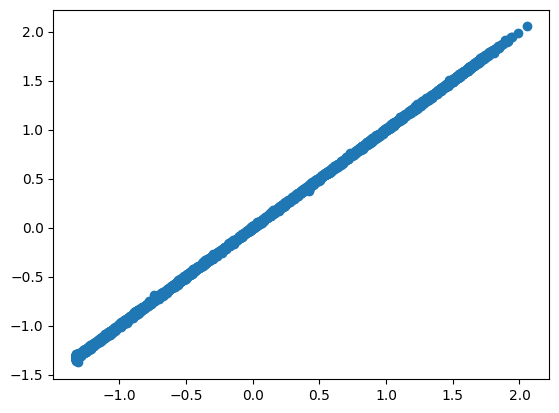

In [12]:
plt.scatter(actual_speed, predicted_speed)

In [13]:
features_model['x_id'][0].shape

(64, 100)

In [14]:
feats_reshaped.shape

(5000, 25600)

In [15]:
model

Neuroformer(
  (tok_emb): Embedding(2026, 256)
  (temp_emb): LearntTemporalEmbedding(
    (temp_emb): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (temp_emb_prev): LearntTemporalEmbedding(
    (temp_emb): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (modality_embeddings): ModuleDict()
  (modality_projection_heads): ModuleDict()
  (frame_3d_emb): PositionalEncoding3D()
  (id_drop): Dropout(p=0.2, inplace=False)
  (im_drop): Dropout(p=0.2, inplace=False)
  (drop): Dropout(p=0.2, inplace=False)
  (video_encoder): VideoEncoder(
    (conv_block): Sequential(
      (0): Conv3d(1, 256, kernel_size=(3, 5, 5), stride=(3, 5, 5))
      (1)

In [16]:
title_mapping = {
    'history': 'history',
    'stimulus': 'history + stimulus',
    'state': 'history + stimulus + state'
}

In [17]:
# fit models for each feature

for feature in ['state', 'history', 'stimulus']:
    print(f"Feature: {title_mapping[feature]}")
    # Reshape feats to be 2-dimensional
    
    feats_reshaped = np.vstack([feat[:, -1].reshape(feat.shape[0], -1) for feat in features_model[feature]])

    # Initialize the model
    reg = LinearRegression()

    # Fit the reg to the data
    reg.fit(feats_reshaped, speed)

    # Now you can use reg.predict() to make predictions
    predicted_speed = reg.predict(feats_reshaped)

    # Calculate the actual speed
    actual_speed = speed

    # Calculate the metrics
    r2 = r2_score(actual_speed, predicted_speed)

    print(f"R2: {r2}")
    print("-----------------")

Feature: history + stimulus + state
R2: 0.635742823843209
-----------------
Feature: history
R2: 0.22999429697899065
-----------------
Feature: history + stimulus
R2: 0.5341393800678469
-----------------


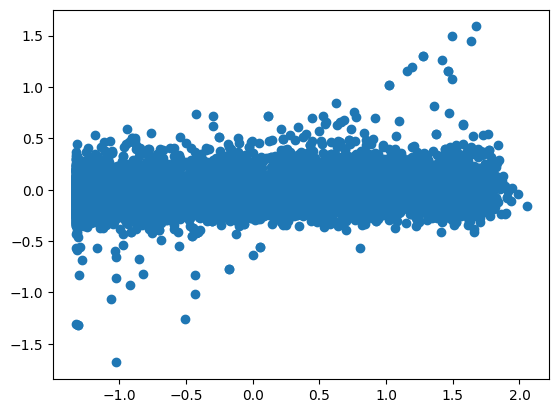

In [19]:
plt.scatter(actual_speed, predicted_speed)

In [20]:
rand_feats = np.random.rand(feats_reshaped.shape[0], feats_reshaped.shape[1])

model_rand = LinearRegression()
model_rand.fit(rand_feats, speed)
pred_rand = model_rand.predict(rand_feats)

r2_rand = r2_score(speed, pred_rand)
print(f"R2: {r2_rand}")


R2: 0.052081271436897336
